# CNN Proof of Concept
This notebook is used to build the Convolutional Neural Network  
and train the data on a small subset of the SALAMI public archive  
data

## Import the required libraries
TensorFlow is used for the building and training the  
model. I make use of the sklearn `train_test_split`  
function to split the data into training and validation  
sets.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import librosa
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Set global variables

I initialise some global variables that will be used in this file  

Some of the values used for the spectrograms are as follows:  
Sample rate: 22050 Hz  
STFT window: 2048 samples  
Hop size: 512 samples  
Mel bins: 64  

In [71]:
SALAMI_DS = "../datasets/salami/salami_open.csv"
SALAMI_LABELS = "../datasets/labels/salami_open/labels.csv"
SALAMI_TRAIN_OUTPUT = "../datasets/splits/salami_open/train.csv"
SALAMI_TEST_OUTPUT = "../datasets/splits/salami_open/test.csv"
SALAMI_IMAGE_PATH = "../spectrograms/s_public/"

## Sample rate
SR = 22050
## Short-time fourier transform window size
N_FFT = 2048
## Hop size or the amount shift
HOP_SIZE = 512
## Number of melbands for the mel-spectrograms
N_MELS = 64
## Window size 
WINDOW_SIZE = 64
## Fixed length for all the spectrograms = duration of longest song
ZERO_PADDING = 32000

In [3]:
salami = pd.read_csv(SALAMI_DS)

In [31]:
def extract_mel_specs(y):
    mel_spec = librosa.feature.melspectrogram(y, sr=SR, n_fft=N_FFT, n_mels=N_MELS, hop_length=HOP_SIZE)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec

In [45]:
lg = extract_mel_specs(first)
lg.shape

dim = lg.shape[1] / 43
dim

32000 / 43 / 60

12.403100775193797

In [ ]:
# sal = pickle.load(open("../dumps/s_public.p", "rb"))

In [ ]:
sal2 = []
mels = []

In [ ]:
for item in tqdm(sal[:50], total=50):
    file_name = item["SONG_ID"]
    log_mel = extract_mel_specs(item["mp3"])
    sal2.append({ "SONG_ID": file_name, "log_mel": log_mel})
    mels.append(log_mel)

In [ ]:
features = []
labels = []

for item in tqdm(sal[:50], total=50):
    if(item["SONG_ID"]):
        file_name = str(item["SONG_ID"])
        file_path = "../datasets/salami/annotations/" + file_name + "/parsed"
        file_one = file_path + "/textfile1_uppercase.txt"
        file_two = file_path + "/textfile2_uppercase.txt"
        try:
            t = pd.read_table(file_one, header=None)
            log_mel = extract_mel_specs(item["mp3"])
            features.append(log_mel)
            labels.append(t.iloc[:,0])
        except IOError:
            try:
                t = pd.read_table(file_two, header=None)
                log_mel = extract_mel_specs(item["mp3"])
                features.append(log_mel)
                labels.append(t.iloc[:,0])
            except IOError:
                continue

In [ ]:
mel_features = np.round(SR/HOP_SIZE)

label_list = []

for f, l in zip(features, labels):
    label_vec = np.zeros(f.shape[1])
    for segment in l:
        if (segment > 0):
            point = int(np.round(segment*43))
            if(point < len(label_vec)):
                label_vec[point] = 1
    label_list.append(label_vec)


In [ ]:
feature_list = features

In [ ]:
feature_list[0].shape, label_list[0].shape

In [ ]:
f = feature_list[0]
l = label_list[0]

In [ ]:
x = []
y = []

for f, l in zip(feature_list, label_list):
    y1 = np.pad(l, (0, ZERO_PADDING - l.shape[0]), 'constant')
    x1 = []
    for i in f:
        x2 = np.pad(i, (0, ZERO_PADDING - i.shape[0]), 'constant')
        x1.append(x2)
    x.append(x1)
    y.append(y1)

In [ ]:
x_new = []
y_new = []

for x1, y1 in tqdm(zip(x, y), total=len(x)):
    arr1 = []
    arr2 = []
    for index in range(0, ZERO_PADDING, ZERO_PADDING):
        x_arr = np.array(x1)
        x_arr = x_arr[:, index:index+N_MELS]
        arr1.append(x_arr.tolist())
        y_arr = np.array(y1)
        y_arr = y_arr[index:index+N_MELS]
        arr2.append(y_arr.tolist)
    arr1 = np.array(arr1)
    x_new.append(arr1)
    arr2 = np.array(arr2)
    y_new.append(arr2)

In [ ]:
x_new = np.array(x_new)
y_new = np.array(y_new)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2, random_state=42)

x_train = x_train[0:10]
x_test = x_test[0:10]
y_train = y_train[0:10]
y_test = y_test[0:10]

In [547]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(32, (3,3), input_shape=x_train[0].shape, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(42, activation='sigmoid'))

In [548]:
sgd = tf.keras.optimizers.SGD(lr=0.05, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [549]:
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 498, 62, 32)       18464     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 166, 20, 32)       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 164, 18, 64)       18496     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 82, 9, 64)         0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 82, 9, 64)         0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 47232)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)             

In [ ]:
history = model.fit(x_train, y_train, batch_size=10, epochs=5, validation_data=(x_test, y_test))

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
x_test.shape

In [ ]:
y_test.shape

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [ ]:
train_images.shape

In [ ]:
train_labels.shape

In [ ]:
y_train[0].shape

In [ ]:
y_train[0][0]

In [ ]:
pickle.dump(x_new, open('x.p', 'wb'))
pickle.dump(y_new, open('y.p', 'wb'))
pickle.dump(feature_list, open('features.p', 'wb'))
pickle.dump(label_list, open('labels.p', 'wb'))

In [ ]:
for x in x_train:
    for i in x:
        if(i.shape[0] < 64):
            print(i.shape)

In [58]:
x_new = pickle.load(open('../dumps/x.p', 'rb'))
y_new = pickle.load(open('../dumps/y.p', 'rb'))
feature_list = pickle.load(open('../dumps/features.p', 'rb'))
label_list = pickle.load(open('../dumps/labels.p', 'rb'))

In [ ]:
x_new.shap

In [11]:
x_new = np.array(x_new)
y_new = np.array(y_new)

In [13]:
feature_list[0].shape

(64, 13786)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2, random_state=42)

x_train = x_train[0:10]
x_test = x_test[0:10]
y_train = y_train[0:10]
y_test = y_test[0:10]

In [59]:
x = []
y = []

for f, l in zip(feature_list, label_list):
    y1 = np.pad(l, (0, ZERO_PADDING - l.shape[0]), 'constant')
    x1 = []
    for i in f:
        x2 = np.pad(i, (0, ZERO_PADDING - i.shape[0]), 'constant')
        x1.append(x2)
    x.append(x1)
    y.append(y1)

In [65]:
x2 = []
y2 = y

for x3 in x:
    x3 = np.array(x3)
    x2.append(x3.reshape(N_MELS, ZERO_PADDING, 1))

x2 = np.array(x2)
y2 = np.array(y2)

In [66]:
x2[0].shape

(64, 32000, 1)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

# x_train = x_train[0:10]
# x_test = x_test[0:10]
# y_train = y_train[0:10]
# y_test = y_test[0:10]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36, 64, 32000, 1), (36, 32000), (10, 64, 32000, 1), (10, 32000))

In [62]:
arr1 = []
arr2 = []

for y1, y2 in zip(y_train, y_test):
    arr1.append(y1.reshape(ZERO_PADDING))
    arr2.append(y2.reshape(ZERO_PADDING))

y_train = np.array(arr1)
y_test = np.array(arr2)

In [63]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36, 64, 32000, 1), (10, 32000), (10, 64, 32000, 1), (10, 32000))

In [54]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(32, (3,3), input_shape=(x_train.shape[1], x_train.shape[2], 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32000, activation='sigmoid'))

In [55]:
sgd = tf.keras.optimizers.SGD(lr=0.05, decay=1e-4, momentum=0.9, nesterov=True)
loss='categorical_crossentropy'
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])

In [68]:
history = model.fit(x_train, y_train, batch_size=4, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
9/9 [==============================] - 46s 4s/step - loss: 5427.2135 - accuracy: 0.0501 - val_loss: 1004.3732 - val_accuracy: 0.0000e+00
Epoch 2/5
9/9 [==============================] - 37s 4s/step - loss: 1280.5964 - accuracy: 0.0178 - val_loss: 4922.2046 - val_accuracy: 0.6000
Epoch 3/5
9/9 [==============================] - 33s 4s/step - loss: 11919.7099 - accuracy: 0.2776 - val_loss: 60141.8672 - val_accuracy: 0.6000
Epoch 4/5
9/9 [==============================] - 32s 4s/step - loss: 82347.0910 - accuracy: 0.0859 - val_loss: 430848.0938 - val_accuracy: 0.6000
Epoch 5/5
9/9 [==============================] - 33s 4s/step - loss: 412812.5875 - accuracy: 0.2899 - val_loss: 2004064.0000 - val_accuracy: 0.6000


In [580]:
y_train.shape

(10, 500, 64)

In [581]:
y_train[0].reshape(ZERO_PADDING)

array([0., 0., 1., ..., 0., 0., 0.])

In [618]:
x5 = x_train[0]

x5 = x5.reshape(64, 32000, 1)

In [620]:
np.shape(x5)

(64, 32000, 1)

In [607]:
x_new[0].shape

(1, 64, 32000)

In [608]:
x[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [609]:
np.shape(x[0])

(64, 32000)

1/1 - 1s - loss: 2004064.0000 - accuracy: 0.6000


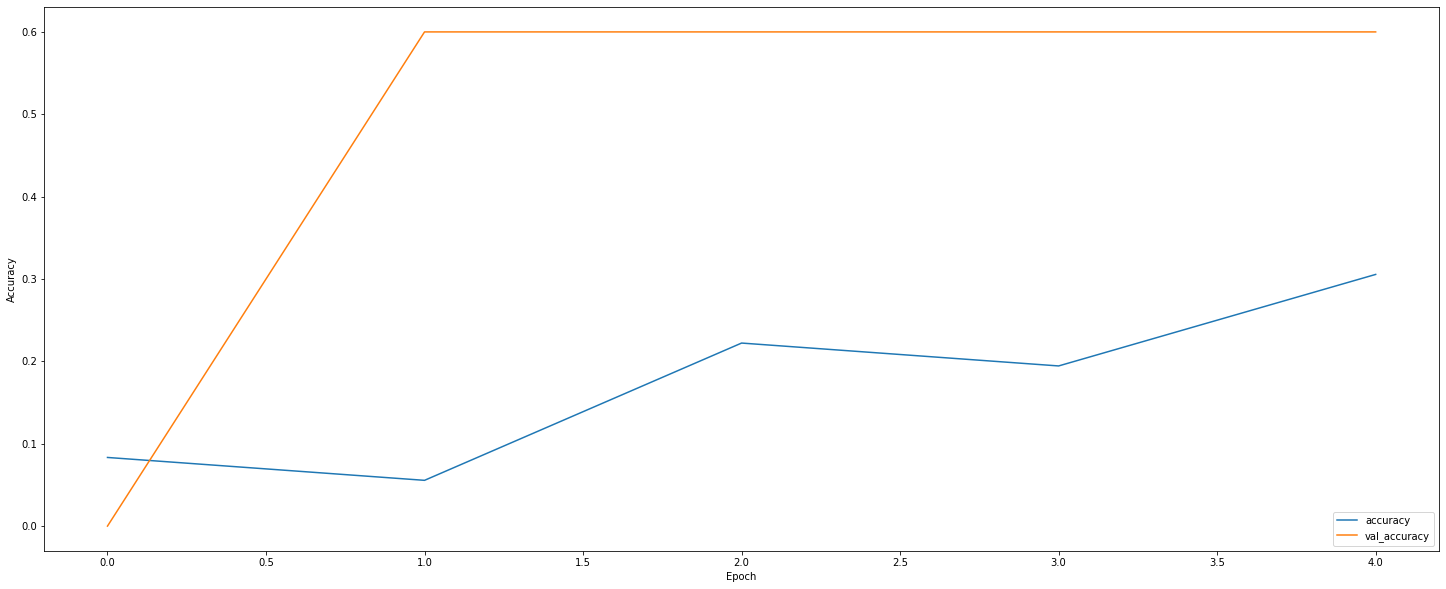

In [69]:
plt.figure(figsize=(25,10))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [636]:
history.history['accuracy']

[0.125, 0.125, 0.1875, 0.1875, 0.4375]

In [2]:
from modules import mel_spectrograms

In [3]:
y = librosa.load("../downloads/s_public/955.mp3", duration=10)

In [4]:
# print(mel_spectrograms.extract_mel_specs(y))
print(mel_spectrograms.extract_mel_specs(y))
# spec = mel_spectrograms.extract_mel_specs(y)
# print(spec)

5
None


In [108]:
librosa.__version__

'0.8.0'